In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#load the data
 
data = pd.read_csv('D:/amazon_alexa.tsv' , delimiter='\t' , quoting = 3)
print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


1...>feedback given
0.....> not given feedback

In [12]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [13]:
print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [14]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [16]:
#getting the record where verified review is null
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [17]:
data.dropna(inplace=True)

In [18]:
print(f"Dataset shape after dropping null values: {data.shape}")

Dataset shape after dropping null values: (3149, 5)


In [19]:
data['length'] = data['verified_reviews'].apply(len)

In [20]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [21]:
#randomly checking 10 record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #original value
print(f"length of review : {len(data.iloc[10]['verified_reviews'])}") # length of review using len()
print(f"'length' column value: {data.iloc[10]['length']}")  #value of column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
length of review : 65
'length' column value: 65


In [22]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

analyzing rating column

In [25]:
len(data)

3149

In [24]:
print(f"rating value count: \n{data['rating'].value_counts()}")

rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


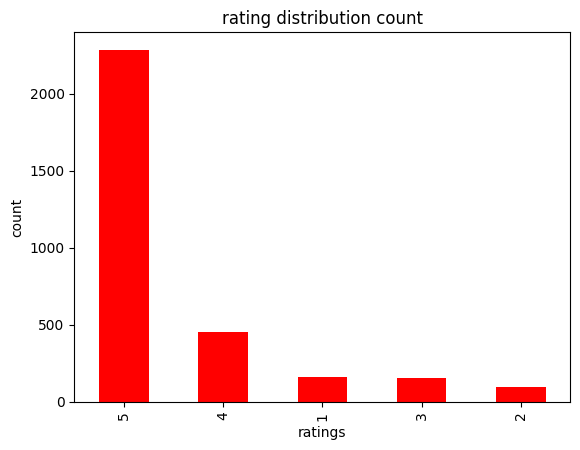

In [27]:
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('rating distribution count')
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

In [28]:
#percentage distribution of each count

round(data['rating'].value_counts()/data.shape[0]*100,2)

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64

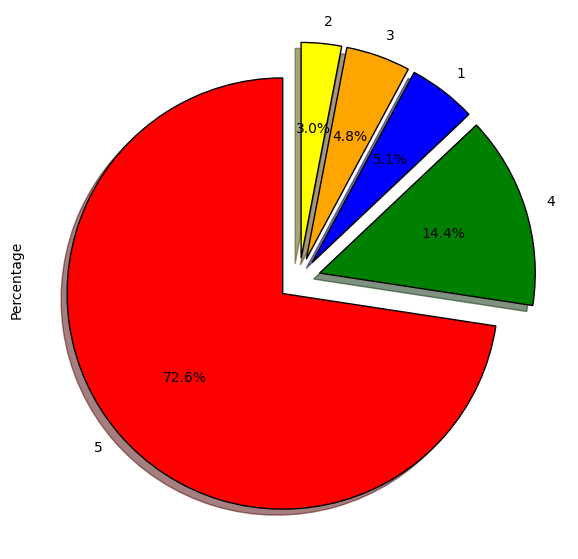

In [31]:
fig = plt.figure(figsize =(7,7))
colors = ('red','green','blue','orange','yellow')
wp = {'linewidth':1,"edgecolor":'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode =(0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie',autopct = '%1.1f%%' , shadow = True , colors = colors , startangle = 90 , wedgeprops = wp , explode = explode , label = 'Percentage')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph , format = 'png')

analyzing feedback column

In [33]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [34]:
review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [35]:
review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


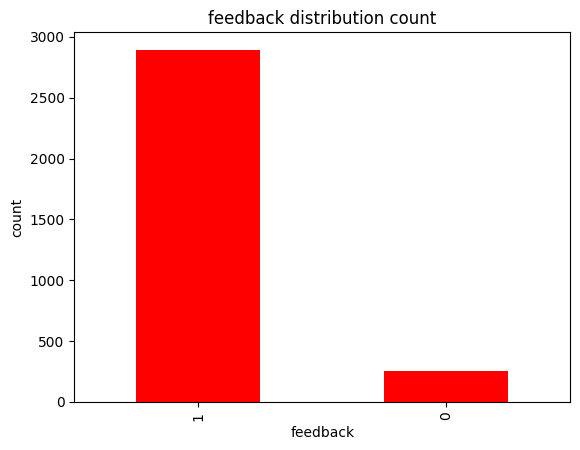

In [36]:
data['feedback'].value_counts().plot.bar(color = 'red')
plt.title('feedback distribution count')
plt.xlabel('feedback')
plt.ylabel('count')
plt.show()

In [38]:
#percentage distribution
round(data['feedback'].value_counts()/data.shape[0]*100,2)

feedback
1    91.87
0     8.13
Name: count, dtype: float64

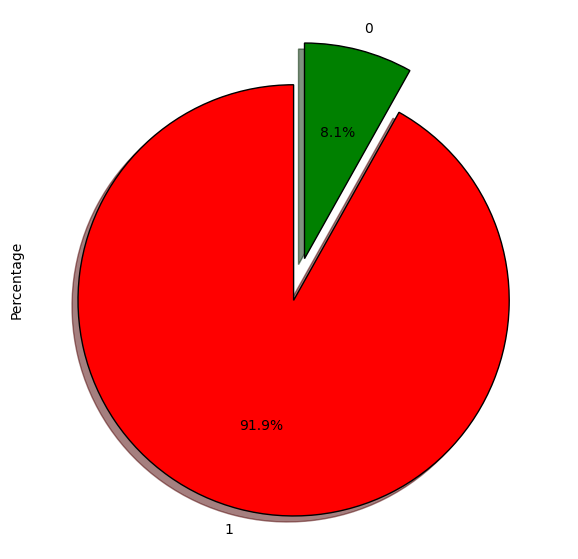

In [39]:
fig = plt.figure(figsize =(7,7))
colors = ('red','green')
wp = {'linewidth':1,"edgecolor":'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode =(0.1,0.1)
tags.plot(kind='pie',autopct = '%1.1f%%' , shadow = True , colors = colors , startangle = 90 , wedgeprops = wp , explode = explode , label = 'Percentage')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph , format = 'png')

In [40]:
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [41]:
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

analyzing variation column

In [42]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

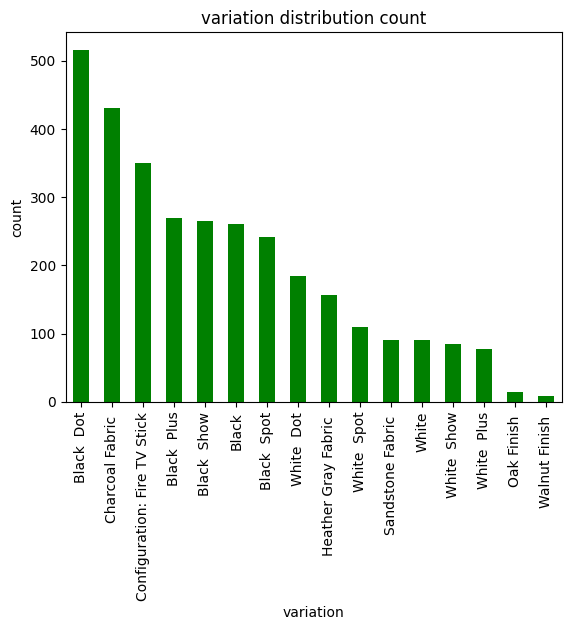

In [44]:
data['variation'].value_counts().plot.bar(color = 'green')
plt.title('variation distribution count')
plt.xlabel('variation')
plt.ylabel('count')
plt.show()

In [46]:
round(data['variation'].value_counts()/data.shape[0]*100,2)

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

In [47]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

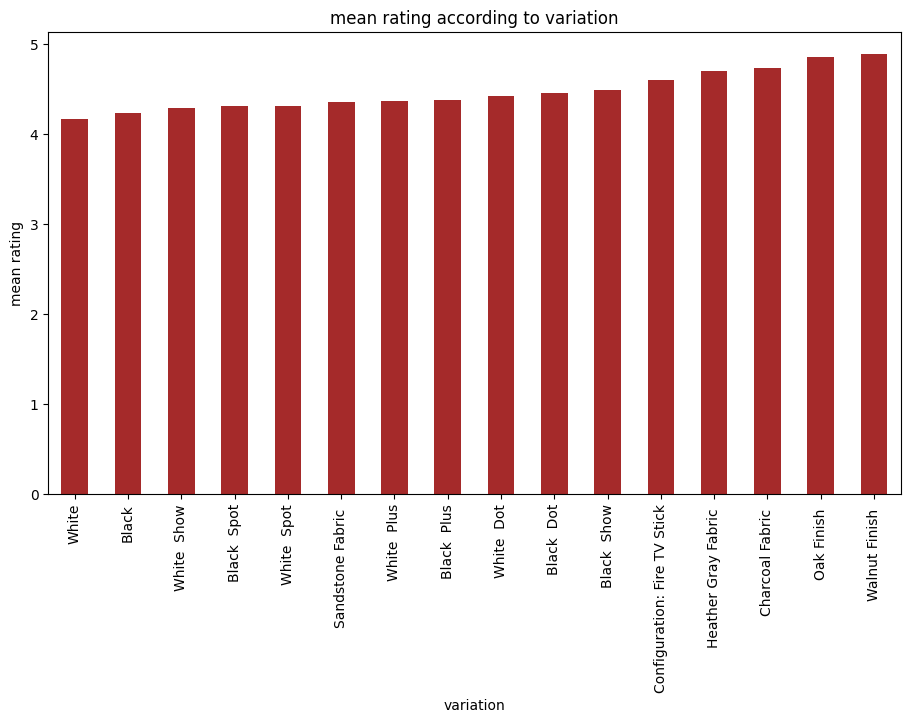

In [48]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11,6))
plt.title('mean rating according to variation')
plt.xlabel('variation')
plt.ylabel('mean rating')
plt.show()

analyzed verified reviews column

In [49]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'distribution of length of review')]

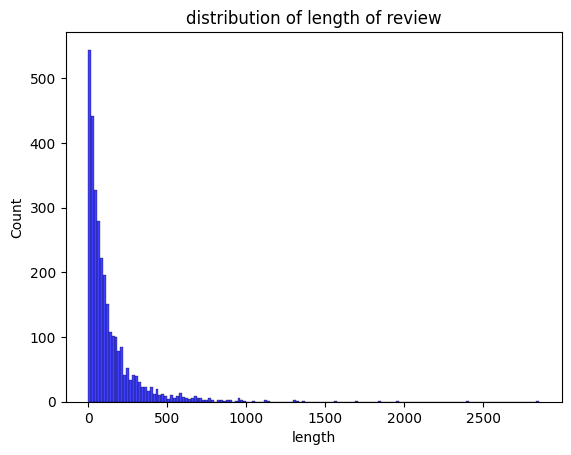

In [50]:
sns.histplot(data['length']  , color = 'blue').set(title = 'distribution of length of review')

[Text(0.5, 1.0, 'distribution of length of review if feedback =0')]

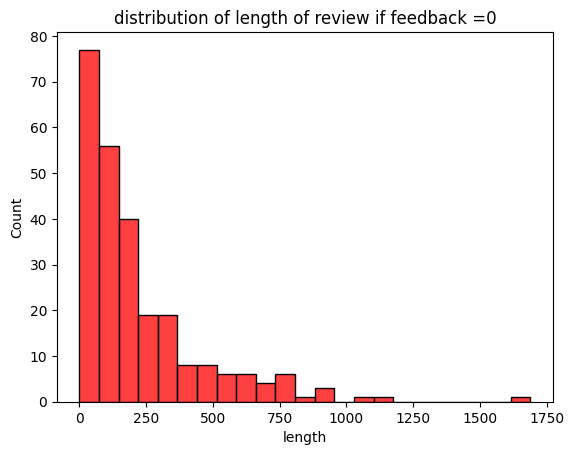

In [51]:
sns.histplot(data[data['feedback']==0]['length'],color = 'red').set(title='distribution of length of review if feedback =0')

[Text(0.5, 1.0, 'distribution of length of review if feedback =1')]

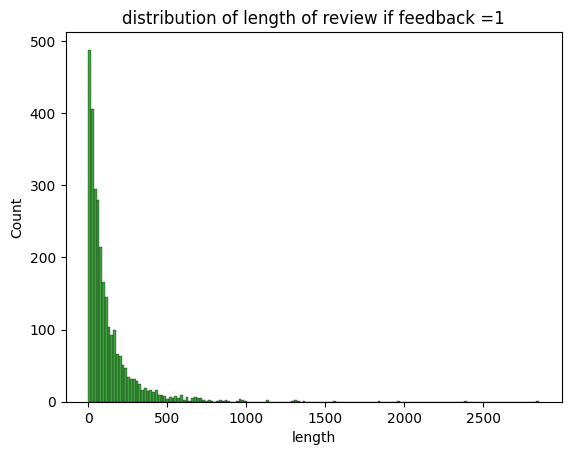

In [54]:
sns.histplot(data[data['feedback']==1]['length'],color = 'green').set(title='distribution of length of review if feedback =1')

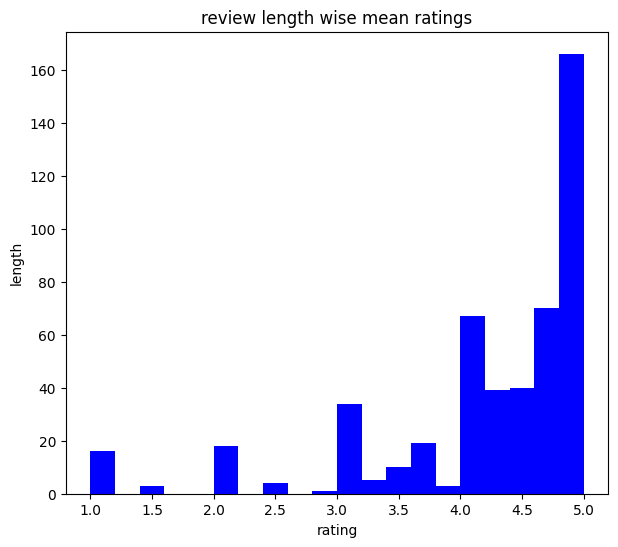

In [55]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7,6),bins=20)
plt.title('review length wise mean ratings')
plt.xlabel('rating')
plt.ylabel('length')
plt.show()

In [56]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

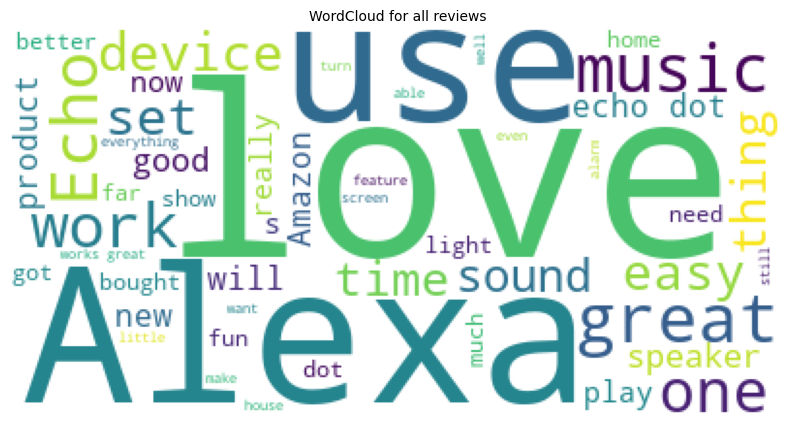

In [66]:
#combine all reviews
reviews = ''.join([review for review in data [ 'verified_reviews']])

#initiatize wordcloud object
wc = WordCloud(background_color='white' , max_words=50)

#generate and plot wordcloud
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud for all reviews' , fontsize  =10)
plt.axis('off')
plt.show()

In [71]:
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data [data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative  = " ".join(unique_negative)

unique_positive = [ x for x in pos_reviews if x not in neg_reviews]
unique_positive  = " ".join(unique_positive)

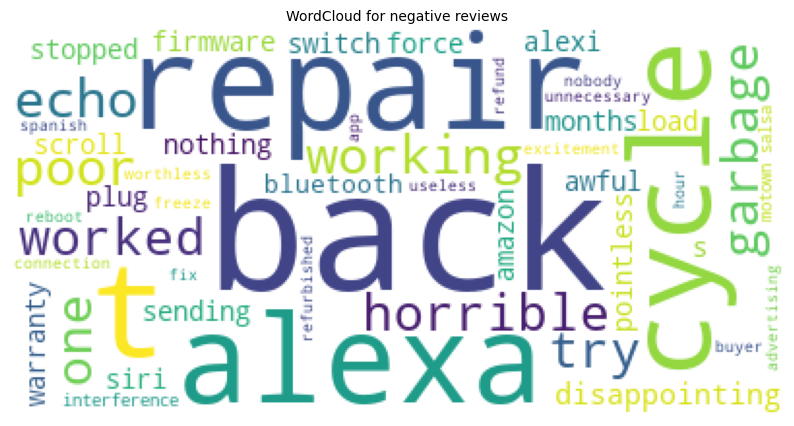

In [72]:
wc = WordCloud(background_color='white' , max_words=50)

#generate and plot wordcloud
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('WordCloud for negative reviews' , fontsize  =10)
plt.axis('off')
plt.show()

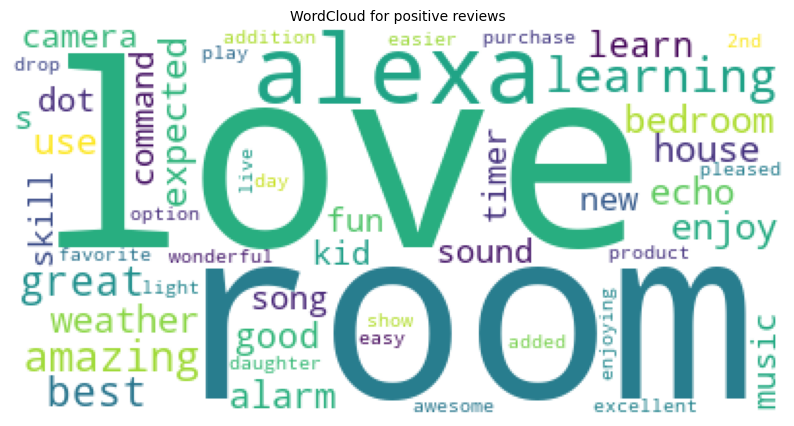

In [73]:
wc = WordCloud(background_color='white' , max_words=50)

#generate and plot wordcloud
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('WordCloud for positive reviews' , fontsize  =10)
plt.axis('off')
plt.show()

Preprocessing and Modelling

to build the corpus from the 'verified reviews'we perform following:
1.replace any non alphabet character with a space
2.convert to lower case and split into words
3.iterate over the indivual words and if it is not a stopword then add the stemmed form of the word to corpus

In [79]:
corpus = []
stemmer = PorterStemmer()
for i in range (0,data.shape[0]):
    review = re.sub('[^a-zA-Z]',' ' , data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [85]:
cv = CountVectorizer(max_features=2500)

#storing independent and dependent variables in x and y
X= cv.fit_transform(corpus).toarray()
Y=data['feedback'].values

In [101]:
import os
os.makedirs('Models',exist_ok=True)

In [102]:
#saving the count vectorize
pickle.dump(cv , open('Models/CountVectorizer.pkl','wb'))

In [104]:
print(f"X shape :{X.shape}")
print(f"Y shape: {Y.shape}")

X shape :(3149, 2500)
Y shape: (3149,)


In [105]:
X_train , X_test , Y_train , Y_test = train_test_split(X,Y , test_size=0.3 , random_state=15)

print(f"X train : {X_train.shape}")
print(f"Y train : {Y_train.shape}")
print(f"X test: {X_test.shape}")
print(f" Y test :{Y_test.shape}")

X train : (2204, 2500)
Y train : (2204,)
X test: (945, 2500)
 Y test :(945,)


In [106]:
print(f"X train max value :{X_train.max()}")
print(f" X test max value :{X_test.max()}")

X train max value :12
 X test max value :10


In [107]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

random forest

In [108]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl , Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [109]:
print(f"triaing accuracy :" , model_rf.score(X_train_scl , Y_train))
print(f"testing accuracy:",model_rf.score(X_test_scl , Y_test))

triaing accuracy : 0.9941016333938294
testing accuracy: 0.9439153439153439


In [110]:
Y_preds = model_rf.predict(X_test_scl)

In [111]:
cm = confusion_matrix(Y_test , Y_preds)

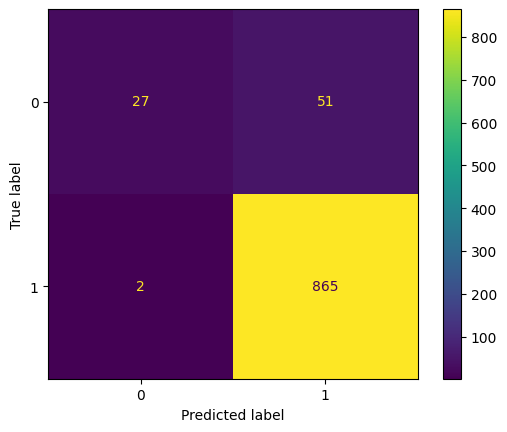

In [112]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

k fold cross validation

In [115]:
accuracies = cross_val_score(model_rf,X_train_scl,Y_train , cv=10)

print("Accuracy:",accuracies.mean())
print("standard variance:",accuracies.std())

Accuracy: 0.9328506787330317
standard variance: 0.006338959166571749


applyin grid search to get the optimal parameter on random forest

In [116]:
params = {
    'bootstrap':[True],
    'max_depth':[80,100],
    'min_samples_split':[8,12],
    'n_estimators':[100,300]
}

In [117]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator = model_rf , param_grid=params , cv=cv_object,verbose = 0 , return_train_score=True)
grid_search.fit(X_train_scl , Y_train.ravel())

,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True], 'max_depth': [80, 100], 'min_samples_split': [8, 12], 'n_estimators': [100, 300]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [118]:
print("Best parameter combination:{}",format(grid_search.best_params_))

Best parameter combination:{} {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [119]:
print("cross validatiom mean accuracy on train set :{}" , format(grid_search.cv_results_['mean_train_score'].mean()*100))
print('cross validationn mean accuracy on test set: {}' , format(grid_search.cv_results_['mean_test_score'].mean()*100))
print('Accuracy score for test set:',accuracy_score(Y_test,Y_preds))

cross validatiom mean accuracy on train set :{} 96.84097096188748
cross validationn mean accuracy on test set: {} 92.12794918330309
Accuracy score for test set: 0.9439153439153439


XG boost

In [120]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl , Y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [121]:
print("training accuracy:" , model_xgb.score(X_train_scl,Y_train))
print("testing accuracy:", model_xgb.score(X_test_scl,Y_test))

training accuracy: 0.9718693284936479
testing accuracy: 0.9375661375661376


In [122]:
Y_preds = model_xgb.predict(X_test)

In [123]:
cm = confusion_matrix(Y_test , Y_preds)
print(cm)

[[ 35  43]
 [ 18 849]]


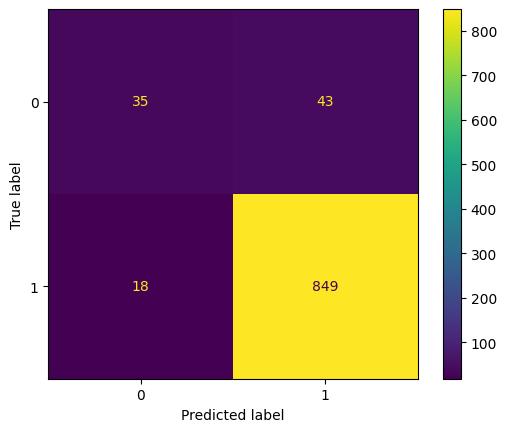

In [124]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [125]:
pickle.dump(model_xgb , open('Models/model_xgb.pkl','wb'))

decision tree classifier

In [126]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl,Y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [127]:
print("training accuracy:" , model_dt.score(X_train_scl,Y_train))
print("testing accuracy:", model_dt.score(X_test_scl,Y_test))

training accuracy: 0.9941016333938294
testing accuracy: 0.9206349206349206


In [128]:
Y_preds = model_dt.predict(X_test)

In [129]:
cm = confusion_matrix(Y_test , Y_preds)
print(cm)

[[ 37  41]
 [ 84 783]]


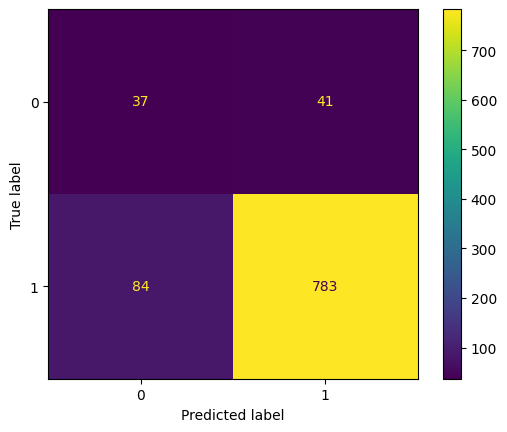

In [130]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=model_dt.classes_)
cm_display.plot()
plt.show()